# Spatial Data

In [2]:
import pandas
import osmnx
import geopandas
import rioxarray
import xarray
import datashader
import contextily as cx
from shapely.geometry import box
import matplotlib.pyplot as plt

This chapter lands the ideas discussed in the previous one on a practical context. We consider how structures, and the models they represent, are implemented in Python, and how we can manipulate the data they contain. Rather than focusing on *file* formats, which are used to store data, we will spend most of the chapter discussing how Python represents it, *once read* from a file or database. We take this approach because it is these data structures that we will interact with when we are analysing data. Part of the magic of Python (and other languages) is that they remove the complexities, particularities and quirks associated with each file format by representing data in standard ways, whichever their provenance. We take full advantage of this feature here. 

We divide the chapter in two main parts. The first one looks at each of the three main data structures reviewed in Chapter 2 (XXX): geographic tables, surfaces and spatial graphs. The second one explores combinations of different models that depart from the traditional data model/structure matching discussed, covering how one data in one structured can be effectively transfered to another, but also focusing on why that might be a good idea in some cases. A final note before we delve into the content of this book is in order: this is not a comprehensive account of *everything* that is possible with each of the data structures we present. Rather, you can think of it as a taster that we will build on throughout the book to showcase much of what is possible with Python.

## Fundamentals

### Geographic Tables

Geographic objects are usually matched to what we called the *geographic table*. This data structure represents a single geographic object as a row of a table; each column in the table records information about the object, its attributes or features, as we will see below. Typically, there is a special column in this table that records the *geometry* of the object. Computer systems that use this data structure are intended to add geography into a *relational database*, such as PostGreSQL (through its PostGIS extension) or sqlite (through its spatialite extension). Beyond this, however, many data science languages (such as R, Julia, and Python), have packages that adopt this data structure as well (such as sf, ArchGDAL, and geopandas), and it is rapidly becoming the main data structure for object-based geographic data. Geographic tables can be thought of as a tab in a spreadsheet where one of the columns records geometric information.

Before proceeding, though, it helps to mention a quick clarification on terminology. Throughout this book, regardless of the data structure used, we will refer to a measurement about an observation as a *feature*. This is consistent with other work in data science and machine learning. Then, one set of measurements is a *sample*. For tables, this means a feature is a column and a sample is a row. Historically, though, geographic information scientists have used the word "feature" to mean an individual observation, since a "feature" in cartography is an entity on a map, and "attribute" to describe characteristics of that observation. Thus, being clear about this terminology is important: for this book, a *feature* is one measured trait pertaining to an observation (a column), and a *sample* is one set of measurements (a row). 

To understand the structure of these datasets, it will help to read in the `countries_clean.gpkg` dataset included in this book that describes countries in the world. To read in this data, we can use the `read_file()` method in `geopandas`:

In [66]:
gt_polygons = geopandas.read_file("../data/countries/countries_clean.gpkg")

And we can examine the top of the table with the method `.head()`:

In [67]:
gt_polygons.head()

,ADMIN,geometry
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102..."
1,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101..."
2,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828...."
4,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."


Each row of this table is a single country. This table shows only two features: the administrative name of the country and the geometry of the country's boundary. The name of the country is encoded in the `ADMIN` column using the Python `str` type, which is used to store text-based data. The geometry of the country's boundary is stored in the `geometry` column, and is encoded using a special class in Python that is used to represent geometric objects. As with other table-based data structures in Python, every row and column have an index that identifies them uniquely and is rendered in bold. Geographic tables in Python are stored as `GeoDataFrame` objects.

Geographic tables store geographic information as an additional column. But, how is this information pertaining to each row encoded to store it? To clarify this, we can check the type of the object in the first row:

In [68]:
type(gt_polygons.geometry[0])

shapely.geometry.multipolygon.MultiPolygon

In `geopandas` (as well as other packages representing geographic data), the `geometry` column has special traits. For example, when we plot the dataframe, the `geometry` column is used as the main shape to use in the plot:

<AxesSubplot:>

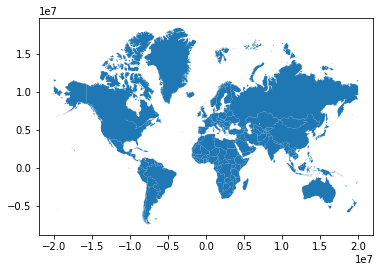

In [69]:
gt_polygons.plot()

Changing geometries must be done carefully: since the `geometry` column is special, there are special functions to adjust the geometry. For example, if we were to represent each country using its *centroid*, a point in the middle of the shape, then we must take care to set the geometry again. For example, when we compute the centroid, we can use the `gt_polygons.geometry.centroid` property and add a new column containing the centroid:

In [70]:
gt_polygons['centroid'] = gt_polygons.geometry.centroid

In [71]:
gt_polygons.head()

,ADMIN,geometry,centroid
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102...",POINT (13055431.810 -248921.141)
1,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101...",POINT (12211696.493 422897.505)
2,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",POINT (-7959811.948 -4915458.802)
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828....",POINT (-7200010.945 -1894653.148)
4,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",POINT (-8277554.831 -1032942.536)


We can switch to the centroid column using the `set_geometry()` method. This can be useful when you want to work with two different geometric representations of the same underlying sample. For example, to plot the centroid and the boundary of each country by switching the geometry column with `set_geometry`:

<AxesSubplot:>

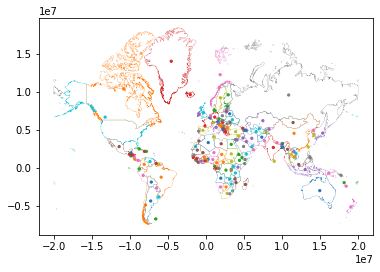

In [72]:
# Plot centroids
ax = gt_polygons.set_geometry('centroid')\
                .plot('ADMIN', 
                      markersize=5
                     )
# Plot polygons without color filling
gt_polygons.plot('ADMIN', 
                 ax=ax, 
                 facecolor='none', 
                 edgecolor='k', 
                 linewidth=.2
                )

Note how we can create a map by calling `.plot()` on a `GeoDataFrame`. We can color thematically each feature based on a given column by passing the name of that column to the plot engine (as we do on with `ADMIN` on this case).

Thus, as should now be clear, nearly any kind of geometric object can be represented in one (or more) geometry column(s). Thinking about the number of different kinds of shapes or geometries one could draw quickly boggles the mind. Fortunately the Open Geospatial Consortium (OGC) has defined a set of "abstract" types that can be used to define any kind of geometry. This specification, codified in ISO 19125-1, the "simple features" specification, specifies the formal relationships between these types: a `Point` is a zero-dimensional location with an x and y coordinate; a `LineString` is a path composed of a set of more than one `Point`, and a `Polygon` is a surface that has  at least one LineString that starts and stops with the same coordinate. All of these types *also* have "Multi-" variants that indicate a collection of multiple geometries of the same type. So, for instance, Bolivia is represented as a single polygon:

In [73]:
gt_polygons.query('ADMIN == "Bolivia"')

,ADMIN,geometry,centroid
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828....",POINT (-7200010.945 -1894653.148)


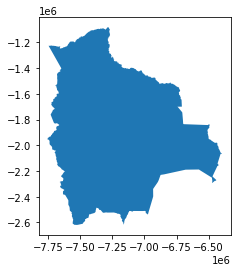

In [74]:
gt_polygons.query('ADMIN == "Bolivia"').plot();

while Indonesia is a `MultiPolygon` containing  many `Polygons` for each individual island in the country:

In [75]:
gt_polygons.query('ADMIN == "Indonesia"')

,ADMIN,geometry,centroid
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102...",POINT (13055431.810 -248921.141)


<AxesSubplot:>

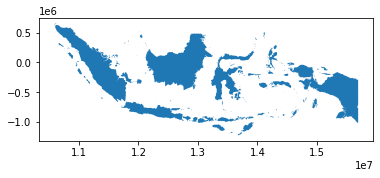

In [76]:
gt_polygons.query('ADMIN == "Indonesia"').plot()

Normally, geographic tables will only have geometries of a single type; records will *all* be `Point` or `LineString`, for instance. However, there is no formal requirement that a *geographic table* has geometries that all have the same type. 

Throughout this book, we will use geographic tables extensively, storing polygons, but also points and lines. We will explore lines a bit more in the second part of this chapter but, for now, let us stop on points for a second. As mentioned above, these are the simplest type of feature in that they do not have any dimension, only a pair of coordinates attached to them. This means that points can sometimes be stored in a non-geographic table, simply using one column for each coordinate. We find an example of this on the Tokyo dataset we will use more later. The data is stored as a comma-separated value table, or `.csv`:

In [77]:
points = pandas.read_csv("../data/tokyo/tokyo_clean.csv")

Since we have read it with `pandas`, the table is loaded as a `DataFrame`, with no explicit spatial dimension:

In [78]:
type(points)

pandas.core.frame.DataFrame

If we inspect the table, we find there is not a `geometry` column:

In [79]:
points.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06


Many point datasets are provided in this format. To make the most of them, it is convenient to convert them into `GeoDataFrame` tables. There are two steps involved in this process:

1. Turn coordinates into geometries:

In [80]:
pt_geoms = geopandas.points_from_xy(points["longitude"],
                                    points["latitude"],
                                    crs="EPSG:4326"
                                   )

2. Create a `GeoDataFrame` object:

In [81]:
gt_points = geopandas.GeoDataFrame(points,
                                   geometry=pt_geoms
                                  )

And now `gt_points` looks and feels exactly like the one of countries we have seen before, with the difference the `geometry` column stores `POINT` geometries:

In [82]:
gt_points.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y,geometry
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06,POINT (139.70050 35.67400)
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06,POINT (139.76652 35.70909)
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06,POINT (139.76563 35.69448)
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06,POINT (139.78439 35.54859)
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06,POINT (139.76875 35.67152)


### Surfaces

Surfaces record data conceptualised as a field. In theory, a field is a continuous surface and thus has an infinite number of locations at which it could be measured. In reality however, fields are measured and recorded at a finite sample of locations that, to provide a sense of continuity and better conform with the field model, are uniformly structured across space. Surfaces thus, are represented as grids where each cell contains a sample. A grid can also be thought of as a table with rows and columns but, as we discussed in the previous chapter, both of them are directly tied to geographic location. This is in sharp contrast with geographic tables, where geography is confined to a single column.

To explore how Python represents surfaces, we will use an extract for the Brazillian city of Sao Paulo of a [global population dataset](../data/ghsl/build_ghsl_extract). This dataset records population counts in cells of the same dimensions uniformly covering the surface of the Earth. Our extract is available as a GeoTIF file, a variation of the TIF image format that includes geographic information. We can use the `xarray` package to read it in:

In [83]:
pop = xarray.open_rasterio("../data/ghsl/ghsl_sao_paulo.tif")

which reads the data into a `DataArray` object:

In [84]:
type(pop)

xarray.core.dataarray.DataArray

`xarray` is a library to work with multi-dimensional, labelled arrays. Let's unpack this: we can use arrays of not only two dimensions as in a table with rows and columns, but with an arbitrary number of them; each of these dimensions are "tracked" by an index that makes it easy and efficient to manipulate. In `xarray`, these indices are called coordinates, and they can be retrieved from our `DataArray` through the `coords` attribute:

In [85]:
pop.coords

Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06

Interestingly, our surface has *three* dimensions: `x`, `y`, and `band`. The former to track the latitude and longitude that each cell in our population grid covers. The third one has a single value (1) and, in this context, it is not very useful. But it is easy to imagine contexts where a third dimension would be useful: time series, as in the case of geocubes that we discussed in Chapter 2); or multi-band surfaces such as satellite data where different bands are recorded for a given scene (the clearest case perhaps being optical images where there is one band for red, one for green and another one for blue, the three together making up the color of a pixel). A geographic surface will thus have two dimensions recording location, and potentially more recording other dimensions pertaining to our data.

An `xarray.DataArray` object contains additional information about the values stored under the `attrs` attribute:

In [86]:
pop.attrs

{'transform': (250.0, 0.0, -4482000.0, 0.0, -250.0, -2822000.0),
 'crs': '+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True',
 'res': (250.0, 250.0),
 'is_tiled': 0,
 'nodatavals': (-200.0,),
 'scales': (1.0,),
 'offsets': (0.0,),
 'AREA_OR_POINT': 'Area',
 'grid_mapping': 'spatial_ref'}

In this case, we can see this includes information required to convert pixels in the array into locations on the Earth surface (e.g. `transform`, and `crs`), the resolution (250 metres by 250 metres), and other metadata that allows us to better understand where the data come from and how it is stored.

Our `DataArray` has thus three dimensions:

In [87]:
pop.shape

(1, 416, 468)

A common operation will be to reduce it to only the two geographic ones. We can do this with the `sel` operator, which allows us to select data by the value of their coordinates:

In [88]:
pop.sel(band=1)

<xarray.DataArray (y: 416, x: 468)>
[194688 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06
Attributes:
    transform:      (250.0, 0.0, -4482000.0, 0.0, -250.0, -2822000.0)
    crs:            +proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +...
    res:            (250.0, 250.0)
    is_tiled:       0
    nodatavals:     (-200.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

The resulting object is thus a two-dimensional array. Similarly as with geographic tables, we can quickly plot the values in our dataset:

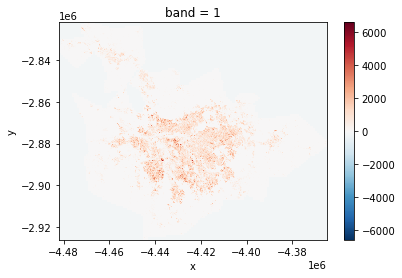

In [89]:
pop.sel(band=1).plot()

This gives us a first overview of the distribution of population in the Sao Paulo region. However, if we inspect further, we can see that the map includes negative counts! How could this be? As it turns out, missing data are traditionally stored in surfaces not as a class of its own (e.g. `NaN`) but with an impossible value. If we return to the `attrs` printout above, we can see how the `nodatavals` attribute specifies missing data recorded with -200. With that in mind, we can use the `where` operator to select only values that are *not* -200:

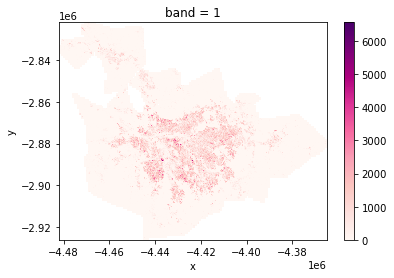

In [90]:
pop.where(pop!=-200)\
   .sel(band=1)\
   .plot(cmap="RdPu")

The colorbar now looks more sensible.

### Spatial graphs

Spatial graphs store connections between objects mediated through space. These connections may derive from geographical topology (e.g. contiguity), distance, or more sophisticated dimensions such as interaction flows (e.g. commuting, trade). Compared to geographic tables and surfaces, spatial graphs are rather different "animals". First, in most cases they do not record measurements about a given phenomena, but instead focus on *connections*, on storing relationships between objects as they are facilitaded (or impeded in their absence) by space. Second, because of this relational nature, data are organised in a more unstructured fashion: while one sample may be connected to only one other sample, another one can display several links. This in stark contrast to geographic tables and surfaces, both of which have a clearly defined structure, shape and dimensionality in which data are organised. These particularities translate into a different set of Python data structures. Unlike the previous ones we have seen, there are different data structures to represent spatial graphs, each optimised for different contexts. One of such cases is the integration of spatial connections in statistical methods such as exploratory data analysis or regression. For this, the most common data structure are spatial weights matrices, to which we devote the next chapter. 

In this chapter, we briefly review a different way of representing spatial graphs that is much closer to the mathematical concept of a graph. For the illustration, we will rely on the `osmnx` library, which can query data from OpenStreetMap. For example, we extract the street-based graph of Yoyogi Park, in Tokyo:

In [3]:
%%time
graph = osmnx.graph_from_place("Yoyogi Park, Shibuya, Tokyo, Japan")

CPU times: user 1.97 s, sys: 45.7 ms, total: 2.02 s
Wall time: 17.7 s


The code snippet above sends the query to the OpenStreetMap server, which returns back the data to `osmnx` to process it as the `graph` Python representation.

In [4]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

We can have a quick inspection of the structure of the graph with the `plot_graph` method:

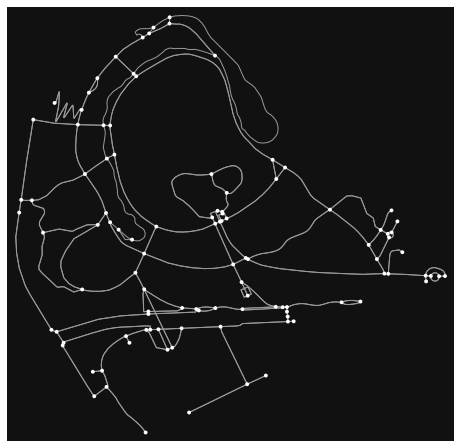

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [13]:
osmnx.plot_graph(graph)

The returning object is a `MultiDiGraph` from `networkx`, a graph library written in Python. The graph here is stored as a collection of 106 nodes (street intersections):

In [7]:
len(graph.nodes)

106

and 287 edges (streets) that connect them:

In [8]:
len(graph.edges)

287

Each of these elements can be queried to obtain more information such as the location and ID of a node:

In [15]:
graph.nodes[1520546819]

{'y': 35.6711267, 'x': 139.6925951, 'osmid': 1520546819}

The characteristics of an edge:

In [18]:
graph.edges[(1520546819, 3010293622, 0)]

{'osmid': 138670840,
 'highway': 'footway',
 'oneway': False,
 'length': 59.113,
 'geometry': <shapely.geometry.linestring.LineString at 0x7f3552e76c10>}

Or how the different components of the graph relate to each other. For example, what other nodes are directly connected to the observation `1520546819`?

In [26]:
list(graph.adj[1520546819].keys())

[3010293622, 5764960322, 1913626649, 1520546959]

## Hybrids

We have just seen how geographic tables, surfaces and networks map onto `GeoDataFrame`, `DataArray` and `Graph` objects in Python, respectively. These represent the pairings that, conceptually, best align data models and structures with Python representations. In this second section of the chapter, we step a bit "out of the box", and explore ways and situations in which it may make sense to represent a dataset with a data structure that might not be the most obvious initial choice. It is interesting to note that many of these cases are driven by technology enabling approaches that were not possible in the past, or creating situations (e.g. large datasets) that make the traditional approach limiting.

### Surfaces as tables

- Read surface

In [32]:
surface = xarray.open_rasterio("../data/ghsl/ghsl_sao_paulo.tif")

- Transfer to `pandas`

In [33]:
t_surface = surface.to_series()

- It's a standard tabular structure, we can use all we know about `pandas`!

In [34]:
t_surface.head()

band  y           x         
1     -2822125.0  -4481875.0   -200.0
                  -4481625.0   -200.0
                  -4481375.0   -200.0
                  -4481125.0   -200.0
                  -4480875.0   -200.0
dtype: float32

In [35]:
t_surface = t_surface.reset_index().rename(columns={0: "Value"})

- If we want to convert the table into a geo-table

In [36]:
def row2cell(row, res_xy):
    res_x, res_y = res_xy
    minX = row["x"]
    maxX = row["x"] + res_x
    minY = row["y"] + res_y
    maxY = row["y"]
    poly = box(minX, minY, maxX, maxY)
    return poly

- For example, we can pull out cells with more than 1,000m and create a geo-table with those

In [37]:
max_polys = t_surface.query("Value > 1000")\
                     .apply(row2cell, 
                            res_xy=surface.attrs["res"], 
                            axis=1
                           )
max_polys = geopandas.GeoSeries(max_polys, crs=surface.attrs["crs"])

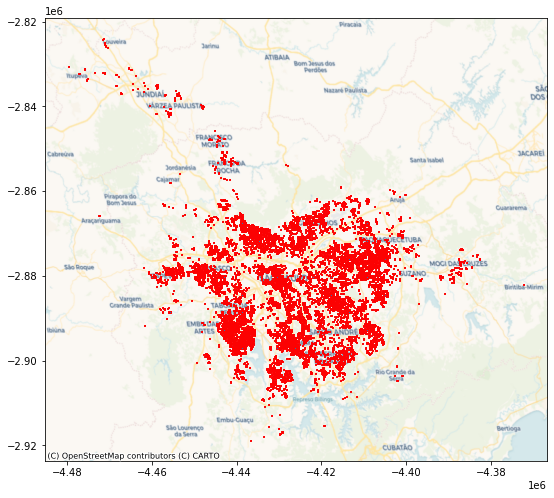

In [38]:
ax = max_polys.plot(edgecolor="red", 
                    figsize=(9, 9)
                   )
cx.add_basemap(ax, 
               crs=surface.attrs["crs"], 
               source=cx.providers.CartoDB.Voyager
              )

We can also use the data with our favorite analytics library that relies on `pandas` (e.g. `sklearn`, `statsmodels`, `pysal`)

- Convert back to `xarray`

In [39]:
new_da = xarray.DataArray.from_series(t_surface.set_index(["band", "y", "x"])["Value"])
new_da

<xarray.DataArray 'Value' (band: 1, y: 416, x: 468)>
array([[[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]]], dtype=float32)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.926e+06 -2.926e+06 ... -2.822e+06 -2.822e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06

---

A second use case of moving surfaces to geo-tables involves aggregating values into geometries specified. Imagine we want to know the average altitude of a neighbourhood. 

For the illustration, we will load the elevation surface for San Diego:

In [40]:
dem

<xarray.DataArray (band: 1, y: 416, x: 468)>
array([[[-200., -200., ..., -200., -200.],
        [-200., -200., ..., -200., -200.],
        ...,
        [-200., -200., ..., -200., -200.],
        [-200., -200., ..., -200., -200.]]], dtype=float32)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06
Attributes:
    transform:      (250.0, 0.0, -4482000.0, 0.0, -250.0, -2822000.0)
    crs:            +proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +...
    res:            (250.0, 250.0)
    is_tiled:       0
    nodatavals:     (-200.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

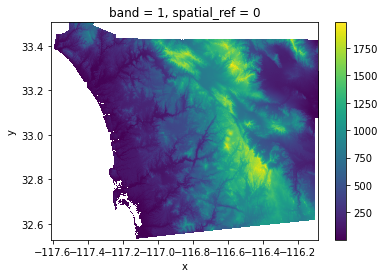

In [41]:
dem = rioxarray.open_rasterio("../data/nasadem/nasadem_sd.tif").sel(band=1)
dem.where(dem > 0).plot.imshow()

And the neighbourhood areas (tracts) from the Census:

<AxesSubplot:>

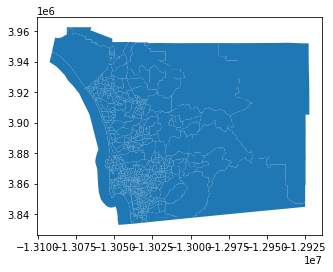

In [42]:
sd_tracts = geopandas.read_file("../data/sandiego/sandiego_tracts.gpkg")
sd_tracts.plot()

There are several approaches to do this, we will use `rioxarray` which allows you clip parts of the surface *within* a given set of geometries. Let's start with a single polygon. For the illustration, we will use the largest one, located on the eastern side of the region.

Find the ID of the polygon:

In [43]:
largest_tract_id = sd_tracts.query(f"area_sqm == {sd_tracts['area_sqm'].max()}").index[0]
largest_tract_id

627

And we can pull out the polygon itself:

In [44]:
largest_tract = sd_tracts.loc[largest_tract_id, "geometry"]

We can then clip the section of the surface that is within the polygon:

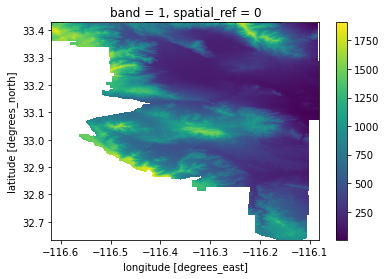

In [45]:
dem_clip = dem.rio.clip([largest_tract.__geo_interface__], 
                        crs=sd_tracts.crs
                       )
dem_clip.where(dem_clip > 0).plot()

If we want to obtain the average elevation of the tract:

In [46]:
dem_clip.where(dem_clip > 0).mean()

<xarray.DataArray ()>
array(585.11375946)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

Now, to scale this to the entire geo-table, there are several approaches, each with benefits and disadvantages. We opt for applying the method above to each row of the table:

In [47]:
def get_mean_elevation(row):
    geom = row["geometry"].__geo_interface__
    section = dem.rio.clip([geom], crs=sd_tracts.crs)
    ele = float(section.where(section > 0).mean())
    return ele

get_mean_elevation(sd_tracts.loc[largest_tract_id, :])

585.1137594576915

And we can apply it, row by row:

In [48]:
%%time
elevations = sd_tracts.head().apply(get_mean_elevation, axis=1)

CPU times: user 4.23 s, sys: 4.07 s, total: 8.3 s
Wall time: 8.39 s


In [49]:
elevations

0      7.144268
1     35.648492
2     53.711389
3     91.358777
4    187.311972
dtype: float64

This approach plays well with `xarray` surface structures and is scalable in that it is not too involved to run in parallel and distributed with Dask, but it's not the most performant. An alternative is using `rasterstats`:

In [50]:
%%time
from rasterstats import zonal_stats

elevations2 = zonal_stats(sd_tracts.to_crs(dem.rio.crs),
                          "../data/nasadem/nasadem_sd.tif"
                         )
elevations2 = pandas.DataFrame(elevations2)

CPU times: user 10.9 s, sys: 2.46 s, total: 13.4 s
Wall time: 37.4 s


In [51]:
elevations2.head()

,min,max,mean,count
0,-12.0,18.0,3.538397,3594
1,-2.0,94.0,35.616395,5709
2,-5.0,121.0,48.742630,10922
3,31.0,149.0,91.358777,4415
4,-32.0,965.0,184.284941,701973


Then this is what we do in the end (more of these approaches in Spatial Feature Engineering):

<AxesSubplot:>

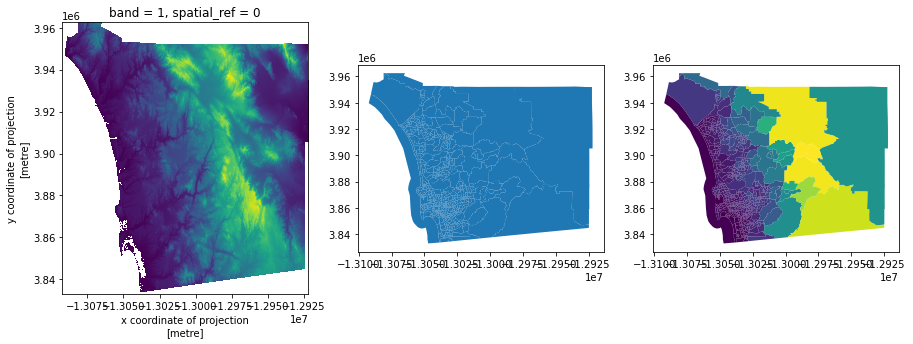

In [52]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
dem.where(dem > 0)\
   .rio.reproject(sd_tracts.crs)\
   .plot.imshow(ax=axs[0], add_colorbar=False)
sd_tracts.plot(ax=axs[1])
sd_tracts.assign(elevation=elevations2["mean"]).plot("elevation", ax=axs[2])

### Tables as surfaces

Discuss cases where, for example you have so many points that there are more than pixels in the screen. Here it makes sense, computationally and conceptually, to aggregate in fine geographies such as grids and store/represent them as such.

Use Tokyo photographs as example for a gridding (e.g. using datashader, which returns `DataArray` objects).

<AxesSubplot:>

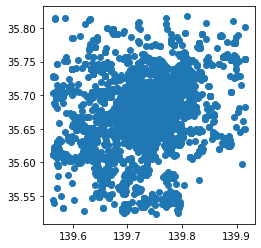

In [53]:
gt_points.plot()

In [54]:
cvs = datashader.Canvas(plot_width=60,
                        plot_height=60
                       )
grid = cvs.points(gt_points, 
                  x="longitude", 
                  y="latitude"
                 )
grid

<xarray.DataArray (latitude: 60, longitude: 60)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]], dtype=uint32)
Coordinates:
  * longitude  (longitude) float64 139.6 139.6 139.6 139.6 ... 139.9 139.9 139.9
  * latitude   (latitude) float64 35.53 35.53 35.54 35.54 ... 35.81 35.81 35.82

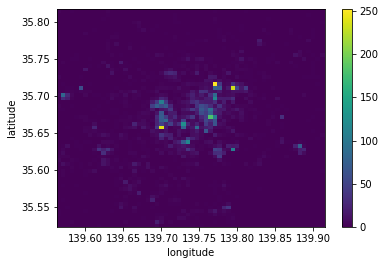

In [55]:
grid.plot()

### Networks as graphs *and* tables

Pick up on the discussion in the last paragraph of [this](https://geographicdata.science/book/notebooks/02_spatial_data.html#computational-represenations-data-structures) and illustrate how a street network can be represented as a graph or a table, what are the data structures in Python for each and how to go from one to the other.

In [56]:
gt_intersections, gt_lines = osmnx.graph_to_gdfs(graph)

[Add trip back]

---
# Questions

1. One way to convert from `Multi-`type geometries into many individual geometries is using the `explode()` method of a GeoDataFrame. Using the `explode()` method, how many islands are in Indonesia?

In [57]:
gt_polygons.query('ADMIN == "Indonesia"').explode()

ADMIN                          centroid  \
0 0    Indonesia  POINT (13055431.810 -248921.141)   
  1    Indonesia  POINT (13055431.810 -248921.141)   
  2    Indonesia  POINT (13055431.810 -248921.141)   
  3    Indonesia  POINT (13055431.810 -248921.141)   
  4    Indonesia  POINT (13055431.810 -248921.141)   
...          ...                               ...   
  259  Indonesia  POINT (13055431.810 -248921.141)   
  260  Indonesia  POINT (13055431.810 -248921.141)   
  261  Indonesia  POINT (13055431.810 -248921.141)   
  262  Indonesia  POINT (13055431.810 -248921.141)   
  263  Indonesia  POINT (13055431.810 -248921.141)   

                                                geometry  
0 0    POLYGON ((13102705.696 463877.598, 13102705.69...  
  1    POLYGON ((13853769.790 -1026334.816, 13855472....  
  2    POLYGON ((13087515.192 463457.874, 13087506.13...  
  3    POLYGON ((15693204.793 -289587.838, 15693206.7...  
  4    POLYGON ((12623095.133 -943744.645, 12624309.0...  
...                                                  ...  
  259  POLYGON ((10970268.273 17736.181, 10974994.068...  
  260  POLYGON ((11657918.548 83454.212, 11659712.270...  
  261  POLYGON ((11650634.949 94167.759, 11651006.376...  
  262  POLYGON ((13934106.805 200321.302, 13934596.00...  
  263  POLYGON ((14152089.356 532099.941, 14153067.75...  

[264 rows x 3 columns]